In [1]:
import torch
from torch import nn
import numpy as np
import os
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_inline import backend_inline
import time

In [2]:
backend_inline.set_matplotlib_formats("svg")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


class MLP(nn.Module):
    def __init__(self, lst: list, act: callable = nn.Tanh):
        super().__init__()
        depth = len(lst) - 1
        layer = []
        for i in range(depth - 1):
            linear = nn.Linear(lst[i], lst[i + 1])
            layer.append(linear)
            layer.append(act())
        layer.append(nn.Linear(lst[-2], lst[-1]))
        self.layer = nn.Sequential(*layer)

    def forward(self, X):
        return self.layer(X)


model = MLP([2] + [50] * 4 + [1]).cuda()
eps = 0.11

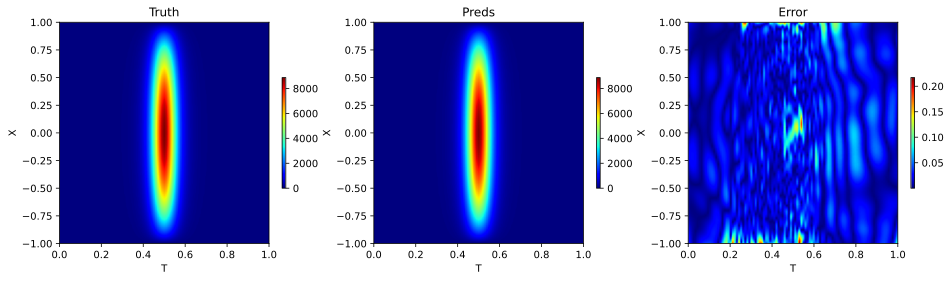

In [3]:
model.load_state_dict(torch.load("./Best_Heat_Large_Gradient.pt"))
p = np.linspace(-1, 1, 201)
q = np.linspace(0, 1, 101)
P, Q = np.meshgrid(p, q, indexing="ij")
datasets = np.concatenate([P.flatten()[:, None], Q.flatten()[:, None]], 1)
Truth = (1 - P**2) * np.exp(1 / ((2 * Q - 1) ** 2 + eps))
preds = (
    model(torch.tensor(data=datasets, dtype=torch.float32).cuda())
    .cpu()
    .detach()
    .numpy()
    .reshape(201, 101)
)
extent = [0, 1, -1, 1]
figs, ax = plt.subplots(1, 3, figsize=(16, 4))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]

h1 = ax1.imshow(Truth, cmap="jet", aspect="auto", extent=extent)
ax1.set_title("Truth")
ax1.set_xlabel("T")
ax1.set_ylabel("X")
figs.colorbar(h1, ax=ax1, shrink=0.5, aspect=30, pad=0.05)


h2 = ax2.imshow(preds, cmap="jet", aspect="auto", extent=extent)
ax2.set_title("Preds")
ax2.set_xlabel("T")
ax2.set_ylabel("X")
figs.colorbar(h2, ax=ax2, shrink=0.5, aspect=30, pad=0.05)


h3 = ax3.imshow(np.abs(Truth - preds), cmap="jet", aspect="auto", extent=extent)
ax3.set_title("Error")
ax3.set_xlabel("T")
ax3.set_ylabel("X")
figs.colorbar(h3, ax=ax3, shrink=0.5, aspect=30, pad=0.05)
plt.show()

In [4]:
rel2 = np.linalg.norm(Truth - preds, 2) / np.linalg.norm(Truth, 2)
print("ReL2: ", rel2)

ReL2:  1.0436299880193968e-05


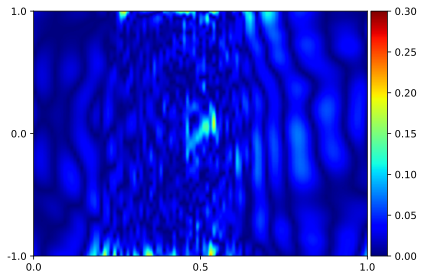

In [6]:
err = np.abs(Truth - preds)
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(6, 4))


ax3 = fig.add_subplot(111)
h3 = ax3.imshow(
    err, cmap="jet", aspect="auto", extent=[0, 1, -1, 1], vmin=0.0, vmax=0.3
)
from matplotlib.colors import LogNorm

xticks = [0, 0.5, 1.0]
xlabels = [0.0, 0.5, 1.0]
plt.xticks(xticks, xlabels)

yticks = [-1.0, 0.0, 1.0]
ylabels = [-1.0, 0.0, 1.0]
plt.yticks(yticks, ylabels)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h3, cax=cax)


plt.tight_layout()
plt.savefig("./Ours_Heat_Error.pdf")